# Datas 

- Source for airports locations: https://openflights.org/data.html (file airlines.dat)
- Source for american airlines and flight scedules: https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236


In [2]:
from visuMultiStream import *
from intervals import *
from structure import *
from elemMSGraph import *
from multiLayers import *
from sortedcollection import *
print("cou")
from matrices import *
from random import *
import seaborn as sns

from tulip import tlp
import scipy.linalg


sorted collection imported
cou


Echelle de temps : 1 semaine

In [3]:
t0=0
tend=24*60*31

print(tend)

interval=Interval(t0,tend)

44640


In [4]:
def convertToMinutes(day,hour,minutes):
    return((day-1)*24*60+hour*60+minutes)



def readAirports(airportl):
    dicoAir={}
    f=open("planes/airports.dat","r",encoding="utf8")
    #print(f)
    lste=[]
    for line in f:
        line=line.replace("\"",'')
        tab=line.split(",")
        ida=tab[4]
        namea=tab[1]
        country=tab[3]
        #print(ida)
        if (ida in dicoAir)==False and (ida in airportl):
            lat=tab[6]
            long=tab[7]
            dicoAir[ida]=[namea,lat,long]
            lste.append(NodeT(ida,IntervalList([interval])))
    return(dicoAir,lste)
    

def readLinks():
    f=open("planes/linksmonth.csv",'r')
    n=0
    em=LinkList([])
    careersl=[]
    airportl=[]
    airportPerLay={}
    for line in f:
        if n>0:
            line=line.replace("\"",'')
            tab=line.split(",")
            date=int(tab[0].split("-")[2])
            career=tab[1]
            origin=tab[2]
            dest=tab[3]
            dept=int(tab[4][0]+tab[4][1])*60+int(tab[4][2]+tab[4][3])
            if len(tab[5])>0:
                arrival=int(tab[6][0]+tab[6][1])*60+int(tab[6][2]+tab[6][3])
                inter=Interval((date-1)*24*60+dept,(date-1)*24*60+arrival)
                if arrival<=dept:
                    inter=Interval((date-1)*24*60+dept,(date)*24*60+arrival)
                if not (career in careersl):
                    careersl.append(career)
                if not (origin in airportl):
                    airportl.append(origin)
                if not (dest in airportl):
                    airportl.append(dest)
                if (career in airportPerLay.keys())==False:
                    airportPerLay[career]=[]
                if not origin in airportPerLay[career]:
                    airportPerLay[career].append(origin)
                if not dest in airportPerLay[career]:
                    airportPerLay[career].append(dest)
                em.addLink(Link(IntervalList([inter]),NodeT(origin,IntervalList([interval])),[career],NodeT(dest,IntervalList([interval])),[career],directed=0),cond=0)
        n=n+1
    return(em,sorted(careersl),sorted(airportl),airportPerLay)

    
def readCarriers(carL):
    f=open("planes/L_UNIQUE_CARRIERS.csv","r")
    n=0
    liste=[]
    dicoCarreer={}
    for line in f :
        if n>0:
            line=line.replace("\"",'')
            tab=line.split(",")
            tab[-1]=tab[-1].rstrip("\n")
            code=tab[0]
            name=tab[1]
            if (code in liste) == False and (code in carL)==True :
                liste.append(code)
                dicoCarreer[code]=name
        n=n+1
    comp=Aspect("carrier",liste)
    return(comp,dicoCarreer)

# Principle :

In the datasets, they are to many airports and carriers (not american and unused). So we begin to read the links to know which airports and carriers are used and we then read their datasets to collect their detailed informations (stored into dictionnaries)

In [5]:
em,carL,airportl,airportperlay=readLinks()

dicoAir,nodes=readAirports(airportl)

laystr=LayerStruct([Aspect("compagnies",carL)])
listLay=[]

carriers,dicoCarreer =readCarriers(carL)

for l in carriers.giveElemLayer():
    nl=NodeTList([])
    for no in airportperlay[l]:
        nl.addNodeT(NodeT(no,IntervalList([interval])))
    listLay.append(Layer(laystr,[l],interval,nl))

layers=LayerList(listLay)

m=MultiStream(interval,laystr,layers,em)          

multi=m.extractML()

extracting...
layer ['9E']
layer ['AA']
layer ['AS']
layer ['B6']
layer ['DL']
layer ['EV']
layer ['F9']
layer ['G4']
layer ['HA']
layer ['MQ']
layer ['NK']
layer ['OH']
layer ['OO']
layer ['UA']
layer ['WN']
layer ['YV']
layer ['YX']


## Build the tulip file

The differents layers corresponding to the different carriers are drawn in different colors. We build different subgraphs corresponding to each company.

This is very useful for vizualisation (download tulip http://tulip.labri.fr/TulipDrupal/ ) to open the graph (double click on the graph on the bottom left and chose the "geographic view"

In [6]:
def makeGraph(m,airportl,carL,dicoAir,airportperlay):
    graph=tlp.newGraph()
    latitude=graph.getDoubleProperty("latitude")
    longitude=graph.getDoubleProperty("longitude")
    name = graph.getStringProperty("nameCity")
    code = graph.getStringProperty("code")
    couche = graph.getStringVectorProperty("compagnie")
    color = graph.getColorProperty("viewColor")
    k=len(carL)
    colList=[(randint(0,255),randint(0,255),randint(0,255)) for i in range(k)]
    for n in range(len(airportl)):
        graph.addNode()
        no=graph.nodes()[n]
        code[no]=airportl[n]
        listeAttributs=dicoAir[airportl[n]]
        name[no]=listeAttributs[0]
        latitude[no]=float(listeAttributs[1])
        longitude[no]=float(listeAttributs[2])
    n=0
    for lay in m.giveLayers().giveLayers():
        car=lay.giveLayerLabel()[0]
        sub=graph.addSubGraph(car)
        nliste=airportperlay[car]
        for node1 in nliste :
            no=graph.nodes()[airportl.index(node1)]
            sub.addNode(no)
        #print(car,len(sub.nodes()))
    for e in m.giveLinks().giveListOfLinks():
        n1=graph.nodes()[airportl.index(e.giveNodes()[0].giveNode())]
        n2=graph.nodes()[airportl.index(e.giveNodes()[1].giveNode())]
        graph.addEdge(n1,n2)
        ed=graph.edges()[n]
        n=n+1
        couche[ed]=e.giveLabel()[2]
        color[ed]=colList[carL.index(e.giveLabel()[2][0])]
        sub=graph.subGraphs()[carL.index(e.giveLabel()[2][0])]
        car=e.giveLabel()[2][0]
        codenode=e.giveNodes()[0].giveNode()
        n1=sub.nodes()[airportperlay[car].index(codenode)]
        n2=sub.nodes()[airportperlay[e.giveLabel()[2][0]].index(e.giveNodes()[1].giveNode())]
        sub.addEdge(ed)
    tlp.saveGraph(graph,"grapheplanes.tp")
    return(graph)

graph=makeGraph(m,airportl,carL,dicoAir,airportperlay)

We can then use the library "tulip" to compute classical measures: 

- page ranking: 

In [8]:
pagerank=graph.getDoubleProperty("pageRank")
params = tlp.getDefaultPluginParameters('Page Rank', graph)
params["directed"]=True

success = graph.applyDoubleAlgorithm('Page Rank', pagerank, params)
pr=[]
for n in graph.getNodes():
    pr.append(pagerank[n])

- betweenness centrality:

In [9]:
betweenness=graph.getDoubleProperty("betweeness")
params = tlp.getDefaultPluginParameters('Betweenness Centrality', graph)
params["directed"]=True

success = graph.applyDoubleAlgorithm('Betweenness Centrality', betweenness, params)
bt=[]
for n in graph.getNodes():
    bt.append(betweenness[n]) 

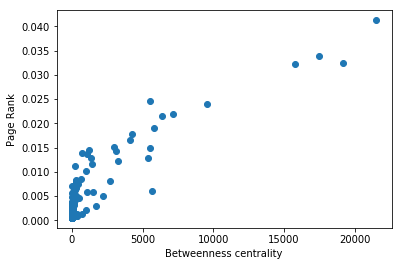

In [11]:
axes = plt.gca()
plt.plot(bt,pr,'o')
axes.set_ylabel('Page Rank')
axes.set_xlabel('Betweenness centrality')
plt.savefig("prVSbc.pdf")
plt.show()


# Intrication

We compute the Burt's matrix which is:

$\begin{pmatrix}
P(1) & P(1|2) & P(1|3) & \dots & P(1|n)\\
P(2|1) & P(2) & P(2|3) & \dots & P(2|n)\\
\vdots & \vdots & \ddots\\
\dots & \dots & \dots & \dots & P(n)
\end{pmatrix}$

$P(i)$ is the probability, taking a flight, that it exists in the compagny $C_i$.

$P(i|j)$ is the probability, taking a flight in $c_j$, that $c_i$ has the same flight.

In [13]:
matintric=multi.computeIntricationMatrixBurt()

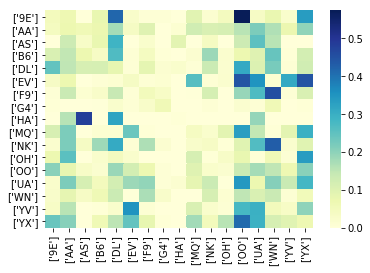

In [14]:
lablist=multi.giveLayersLabels()
sns_plot=sns.heatmap(np.transpose(matintric),cmap="YlGnBu",xticklabels=lablist,yticklabels=lablist)
fig = sns_plot.get_figure()
fig.savefig("intricplanes.pdf")
plt.show()


We compute its maximal left eigenvalue and the eigenvector associated. If the matrix isn't reductible (if we have all the nodes in the same connex component), this eigenvalue is unique and the eigenvector has all its coefficients of the same sign.

In [15]:
valp,vectp=valeurPropreMax(np.transpose(matintric),1000)

We draw the eigenvector ordered:

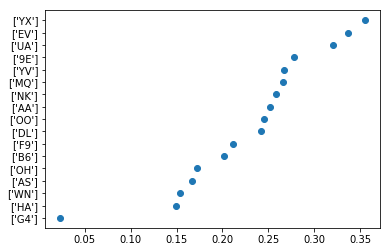

In [16]:
l=SortedCollection(iterable=lablist,key = lambda lab: vectp[lablist.index(lab)])
vectpo,labo=l.listsSorted()

plt.plot(labo,vectpo,'o')
plt.savefig("intricscoresplanes.pdf")
plt.show()

# Random walks

A step: to go on, a passenger will chose among all the possibles links he can take. Each link corresponds to a company and a destination.

For instance, from `['Montgomery Regional (Dannelly Field) Airport', '32.30059814', '-86.39399719']`
we can reach with the same probability:
```
['Hartsfield Jackson Atlanta International Airport', '33.6367', '-84.428101'] with Endeavor Air Inc.
['Hartsfield Jackson Atlanta International Airport', '33.6367', '-84.428101'] with SkyWest Airlines Inc.
['Ronald Reagan Washington National Airport', '38.8521', '-77.037697'] with PSA Airlines Inc.
['Dallas Fort Worth International Airport', '32.896801', '-97.038002'] with Envoy Air
```


In [17]:
def step(pos0,airportl,m,t,prints=False):
    if prints==True:
        print(dicoAir[pos0])
    bloque=False
    possibleLinks=[]
    car="none"
    for link in m.giveLinks().giveListOfLinks():
        if link.giveNodes()[0].giveNode()==pos0:
            possibleLinks.append(link)
            #print(link.giveLabel())
            #print(dicoAir[(link.giveLabel()[1])],dicoCarreer[link.giveLabel()[2][0]])
    if len(possibleLinks)==0:
        bloque=True
        pos1=pos0
        print("no neighbours")
        t1=t
    else:
        #print("----------------------------")
        li=randint(0,len(possibleLinks)-1)
        link0=possibleLinks[li]
        #link0.printLink()
        #print(link0.giveLabel())
        pos1=link0.giveNodes()[1].giveNode()
        intervalsL=link0.giveIntervals()
        i=0
        car=link0.giveLabel()[2][0]
        while i<len(intervalsL) and intervalsL[i].begining()<t :
            i=i+1
        if i==len(intervalsL):
            bloque=True
            t1=t
            print("timeout")
        else:
            t1=intervalsL[i].end()
    return(pos1,t1,car,bloque)

pos0=airportl[randint(0,len(airportl)-1)]
step(pos0,airportl,m,0)

('DFW', 490, 'MQ', False)

From that, we compute the random walk: 

In [19]:
def randomWalk(airportl,m,t,collect="coverage",prints=False,boucles=1):
    pos0=airportl[randint(0,len(airportl)-1)]
    t=0
    bloque=False
    i=0
    b=0
    if collect=="coverage":
        airports=np.array([0 for i in range(len(airportl))])
        compagnies=np.array([0 for i in range(len(carL))])
    if collect=="firstTimeToReach":
        airports=np.array([tend for i in range(len(airportl))])
        compagnies=np.array([tend for i in range(len(carL))])
    while bloque==False and b<boucles:
        if prints==True:
            print(pos0,t)
        pos0,t,car,bloque=step(pos0,airportl,m,t,prints=prints)
        if bloque==True:
            b=b+1
            t=0
            bloque=False
        if collect=="coverage":
            airports[airportl.index(pos0)]=airports[airportl.index(pos0)]+1
            compagnies[carL.index(car)]=compagnies[carL.index(car)]+1
        if collect=="firstTimeToReach":
            if airports[airportl.index(pos0)]==tend:
                airports[airportl.index(pos0)]=t
            if compagnies[carL.index(car)]== tend:
                compagnies[carL.index(car)]=t
        i=i+1
    return([pos0,t,airports,compagnies])

randomWalk(airportl,m,0,prints=True,boucles=10)

SFB 0
['Orlando Sanford International Airport', '28.777599334716797', '-81.23750305175781']
SBN 1988
['South Bend Regional Airport', '41.70869827270508', '-86.31729888916016']
ATL 2320
['Hartsfield Jackson Atlanta International Airport', '33.6367', '-84.428101']
ABQ 2725
['Albuquerque International Sunport', '35.040199', '-106.609001']
PHX 3501
['Phoenix Sky Harbor International Airport', '33.43429946899414', '-112.01200103759766']
SFO 3710
['San Francisco International Airport', '37.61899948120117', '-122.375']
TUS 4144
['Tucson International Airport', '32.1161003112793', '-110.94100189208984']
SEA 5320
['Seattle Tacoma International Airport', '47.449001', '-122.308998']
HNL 5640
['Daniel K Inouye International Airport', '21.32062', '-157.924228']
ANC 7507
['Ted Stevens Anchorage International Airport', '61.174400329589844', '-149.99600219726562']
ORD 8940
["Chicago O'Hare International Airport", '41.9786', '-87.9048']
MHK 9544
['Manhattan Regional Airport', '39.14099884033203', '-96.

SEA 10595
['Seattle Tacoma International Airport', '47.449001', '-122.308998']
ORD 11080
["Chicago O'Hare International Airport", '41.9786', '-87.9048']
timeout
ANC 0
['Ted Stevens Anchorage International Airport', '61.174400329589844', '-149.99600219726562']
PHX 1802
['Phoenix Sky Harbor International Airport', '33.43429946899414', '-112.01200103759766']
FLL 2595
['Fort Lauderdale Hollywood International Airport', '26.072599', '-80.152702']
LAX 3686
['Los Angeles International Airport', '33.94250107', '-118.4079971']
MCO 4230
['Orlando International Airport', '28.429399490356445', '-81.30899810791016']
ORF 5675
['Norfolk International Airport', '36.89459991455078', '-76.20120239257812']
MIA 6310
['Miami International Airport', '25.79319953918457', '-80.29060363769531']
CHS 7811
['Charleston Air Force Base-International Airport', '32.89860153', '-80.04049683']
CLT 8352
['Charlotte Douglas International Airport', '35.2140007019043', '-80.94309997558594']
MHT 8550
['Manchester-Boston Reg

['IAD',
 0,
 array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 4, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0,
        1, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
        6, 4, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,
        3, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 5, 0, 0, 0, 0, 0,
        0, 0, 5, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 4, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 5, 2, 1, 0,
        0, 0, 0, 0, 0, 3, 0, 0, 3, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 

We compute then a great amount of random walks, collecting several informations:

- the coverage

In [35]:
covAirports=np.array([0 for i in range(len(airportl))])
covCompagnies=np.array([0 for i in range(len(carL))])
airports=np.array([0 for i in (airportl)])
t=0
for i in range(10):
    print("randomwalk n", i)
    vect=randomWalk(airportl,m,t,boucles=10)
    airports=vect[2]
    compagnies=vect[3]
    covAirports=np.add(covAirports,airports)
    covCompagnies=np.add(covCompagnies,compagnies)

randomwalk n 0
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 1
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 2
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 3
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 4
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 5
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 6
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 7
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 8
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 9
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout


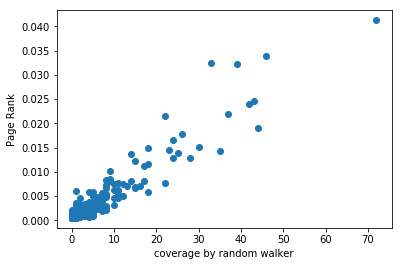

In [21]:
axes = plt.gca()
plt.plot(covAirports,pr,'o')
axes.set_ylabel('Page Rank')
axes.set_xlabel('coverage by random walker')
plt.savefig("prVSrw.pdf")
plt.show()

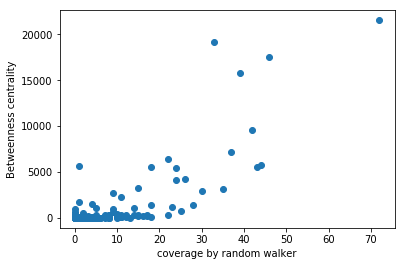

In [22]:
axes = plt.gca()
plt.plot(covAirports,bt,'o')
axes.set_ylabel('Betweenness centrality')
axes.set_xlabel('coverage by random walker')
plt.savefig('bcVScovrw.pdf')
plt.show()

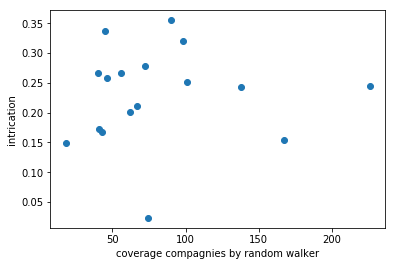

In [23]:
axes=plt.gca()
plt.plot(covCompagnies,vectp,'o')
axes.set_ylabel('intrication')
axes.set_xlabel('coverage compagnies by random walker')
plt.show()


- the first time to reach

In [39]:
ftrAirports=np.array([0 for i in range(len(airportl))])
ftrCompagnies=np.array([0 for i in range(len(carL))])
airports=np.array([0 for i in (airportl)])
t=0
for i in range(10):
    print("randomwalk n", i)
    vect=randomWalk(airportl,m,t,collect="firstTimeToReach",boucles=10)
    airports=vect[2]
    compagnies=vect[3]
    ftrAirports=np.add(covAirports,airports)
    ftrCompagnies=np.add(covCompagnies,compagnies)

randomwalk n 0
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 1
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 2
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 3
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 4
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 5
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 6
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 7
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 8
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 9
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout


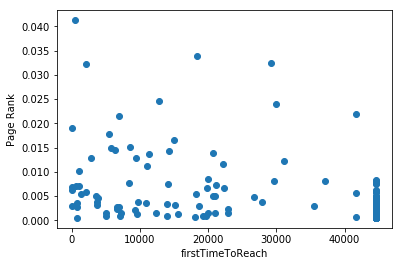

In [40]:
axes = plt.gca()
plt.plot(ftrAirports,pr,'o')
axes.set_ylabel('Page Rank')
axes.set_xlabel('firstTimeToReach')
plt.show()

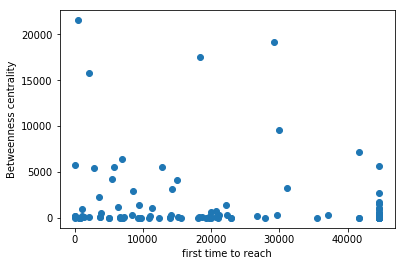

In [41]:
axes = plt.gca()
plt.plot(ftrAirports,bt,'o')
axes.set_ylabel('Betweenness centrality')
axes.set_xlabel('first time to reach')
plt.show()

In [25]:
nnodes=[121,102,70,68,145,101,90,120,18,134,43,95,239,108,85,103,87]
nlinks=[488,721,326,362,834,368,522,614,62,419,366,325,1358,715,1378,335,661]

['9E', 'AA', 'AS', 'B6', 'DL', 'EV', 'F9', 'G4', 'HA', 'MQ', 'NK', 'OH', 'OO', 'UA', 'WN', 'YV', 'YX']


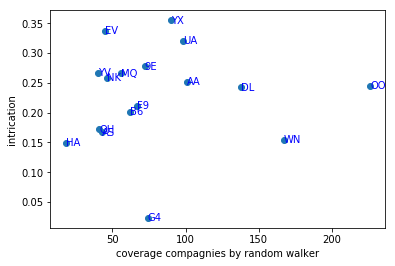

In [26]:
axes=plt.gca()
plt.plot(covCompagnies,vectp,'o')
axes.set_ylabel('intrication')
axes.set_xlabel('coverage compagnies by random walker')
print(carL)
ni=0
for i in carL:
    text = axes.text(covCompagnies[ni],vectp[ni],i,ha="left", va="center", color="b")
    ni=ni+1
plt.show()


[0.49586776859504134, 1.1274509803921569, 1.0285714285714285, 0.7352941176470589, 0.7517241379310344, 0.5643564356435643, 1.1222222222222222, 0.7666666666666667, 0.6111111111111112, 0.5223880597014925, 1.186046511627907, 0.49473684210526314, 0.8786610878661087, 0.9814814814814815, 2.388235294117647, 0.5145631067961165, 1.2873563218390804]


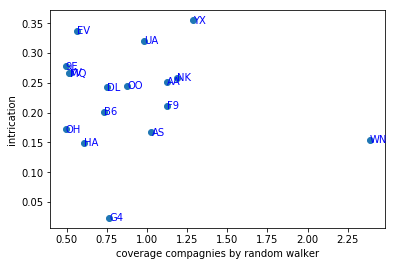

In [37]:
cov2=[covCompagnies[i]/nnodes[i] for i in range(len(carL))]
axes=plt.gca()
plt.plot(cov2,vectp,'o')
axes.set_ylabel('intrication')
axes.set_xlabel('coverage compagnies by random walker')
print(cov2)
ni=0
for i in carL:
    text = axes.text(cov2[ni],vectp[ni],i,ha="left", va="center", color="b")
    ni=ni+1
plt.show()

[0.12295081967213115, 0.15950069348127602, 0.22085889570552147, 0.13812154696132597, 0.13069544364508393, 0.15489130434782608, 0.19348659003831417, 0.1498371335504886, 0.1774193548387097, 0.16706443914081145, 0.13934426229508196, 0.14461538461538462, 0.15463917525773196, 0.14825174825174825, 0.14731494920174165, 0.1582089552238806, 0.16944024205748864]


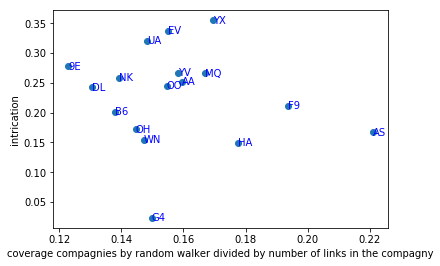

In [36]:
cov3=[covCompagnies[i]/nlinks[i] for i in range(len(carL))]
axes=plt.gca()
plt.plot(cov3,vectp,'o')
axes.set_ylabel('intrication')
axes.set_xlabel('coverage compagnies by random walker divided by number of links in the compagny')
print(cov3)
ni=0
for i in carL:
    text = axes.text(cov3[ni],vectp[ni],i,ha="left", va="center", color="b")
    ni=ni+1
plt.show()